XGBoost Accuracy: 0.996
Classification Report:

Classification Report:
               precision    recall  f1-score   support

     No Rain       1.00      1.00      1.00       437
        Rain       0.97      1.00      0.98        63

    accuracy                           1.00       500
   macro avg       0.98      1.00      0.99       500
weighted avg       1.00      1.00      1.00       500



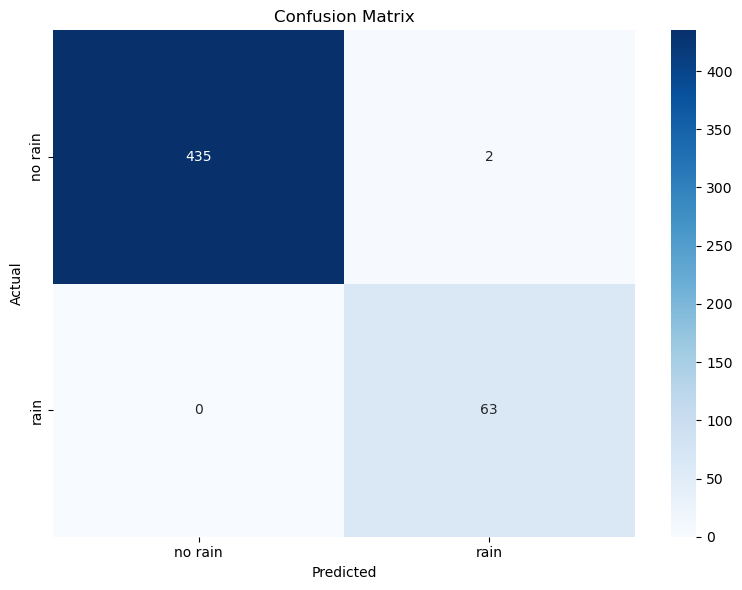

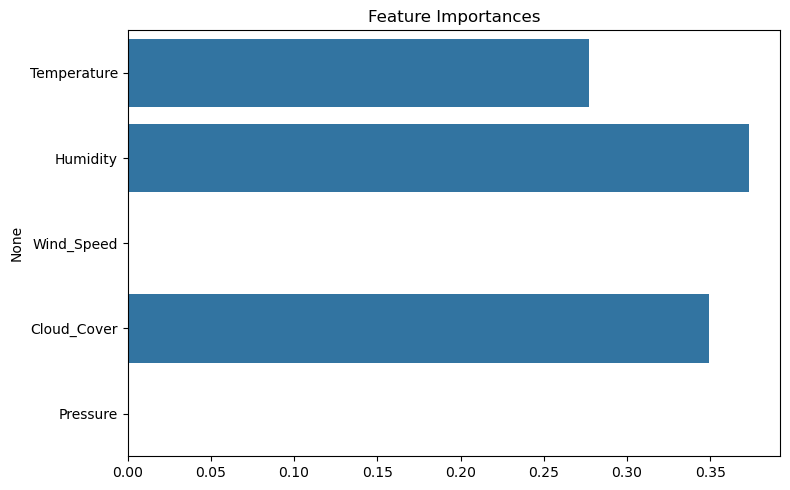

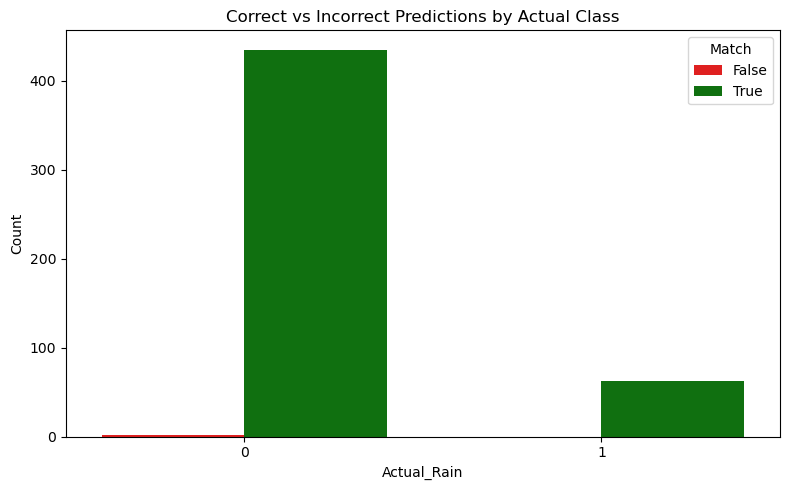

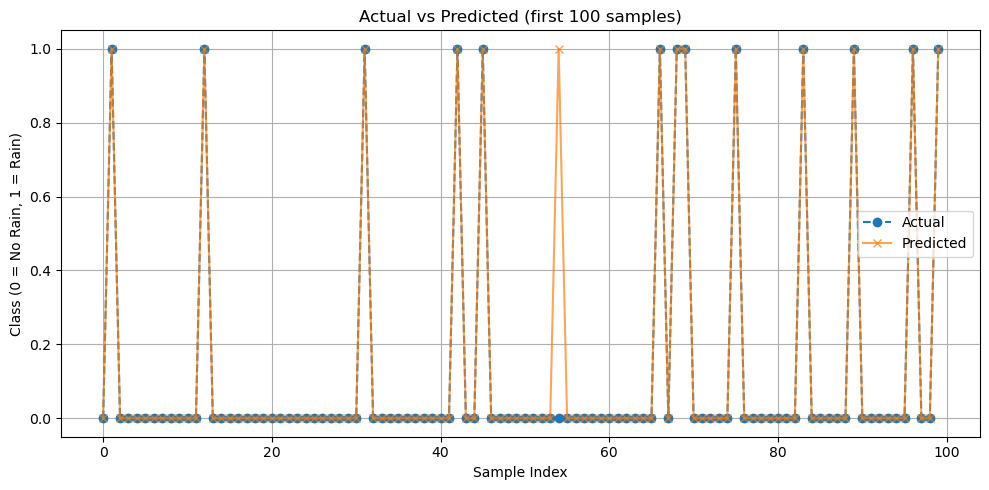

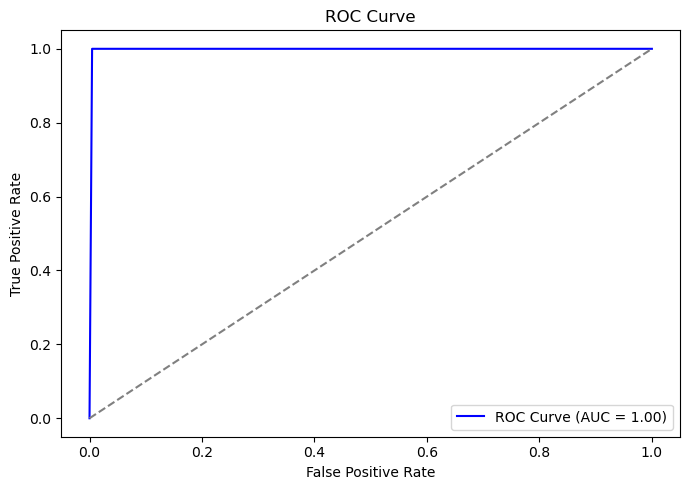

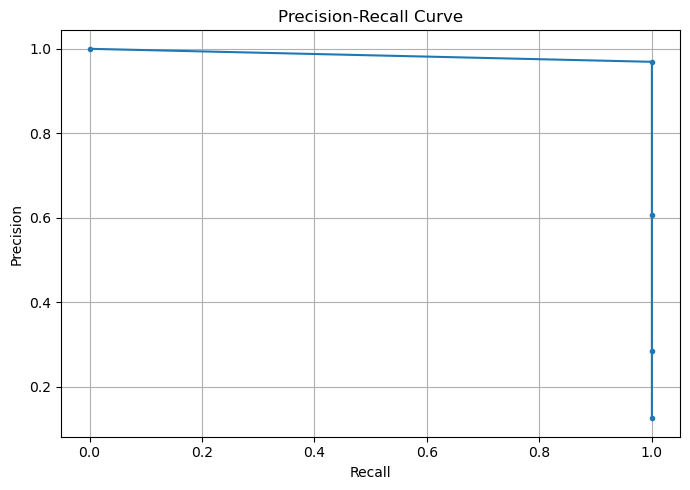

Predicted Weather Outcome: no rain ,for given weather input


C:\Users\oosun\AppData\Local\Temp\ipykernel_7196\1462107811.py:86: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_input = df_input.apply(pd.to_numeric, errors='ignore')


In [4]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

#Step 1: Import CSVs
df_train = pd.read_csv('../Data/train_data.csv', delimiter=",")
df_test = pd.read_csv('../Data/test_data.csv', delimiter=",")

#Step 2: Separate features and target
le = LabelEncoder()

X_train = df_train.drop(columns=["City", "DateTime", "Rain"])
y_train = le.fit_transform(df_train["Rain"])

X_test = df_test.drop(columns=["City", "DateTime", "Rain"])
y_test = le.transform(df_test["Rain"])

#Step 3: Build a pipeline and train XGBoost Model
pipeline = Pipeline(steps=[
    ('clf', XGBClassifier(eval_metric='mlogloss', random_state=47))
])

#Step 4: Define Param grid for tuning the model
param_grid = {
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1],
    'clf__n_estimators': [100, 200]
}

#Step 5: Training the XGBoost model using GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid.fit(X_train, y_train)

predictions = grid.predict(X_test)

best_model = grid.best_estimator_ 

#Step 6: Save the model as pkl file in artifacts
with open("../Artifacts/xgboost_model.pkl", "wb") as file:
   pickle.dump(best_model, file)

#Step 7:Make predictions
predictions = best_model.predict(X_test)

#Step 8: Evaluation
accuracy = accuracy_score(y_test, predictions)
print("XGBoost Accuracy:", accuracy)

print("Classification Report:")
print("\nClassification Report:\n", classification_report(y_test, predictions, target_names=["No Rain", "Rain"], zero_division=0))

#Confusion Matrix
cm = confusion_matrix(y_test, predictions)
labels = le.classes_  
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

#Prediction function
def predict_weather(input_string):
    columns = ["Temperature", "Humidity", "Wind_Speed", "Cloud_Cover", "Pressure"]

    # Convert input string into a list
    input_data = input_string.split(",")

    # Automatically remove the first value (City) and second value (DateTime)
    input_data = input_data[2:] # Removes 1 from start and last 2 items

    df_input = pd.DataFrame([input_data], columns=columns)

    # Convert numerical values from strings to floats
    df_input = df_input.apply(pd.to_numeric, errors='ignore')  

    # Predict using the loaded model
    prediction = best_model.predict(df_input)

    predicted_label = le.inverse_transform([int(prediction[0])])[0]

    return predicted_label

#Step 9: Save predictions to CSV
comp_df = X_test.copy()
comp_df["Actual_Rain"] = y_test
comp_df["Predicted_Rain"] = predictions
comp_df.to_csv("../Data/xgboost_prediction.csv", index=False)

#Feture Importance
importances = best_model.named_steps['clf'].feature_importances_
features = X_train.columns
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

#Ensure predicted probabilities are available
if hasattr(best_model.named_steps['clf'], "predict_proba"):
    probs = best_model.predict_proba(X_test)
    probs_positive_class = probs[:, 1]

    #Match Count Plot
    comp_df["Match"] = comp_df["Actual_Rain"] == comp_df["Predicted_Rain"]
    plt.figure(figsize=(8, 5))
    sns.countplot(data=comp_df, x="Actual_Rain", hue="Match", palette={True: "green", False: "red"})
    plt.title("Correct vs Incorrect Predictions by Actual Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    #Predicted vs Actual Plot (first 100 samples)
    plt.figure(figsize=(10, 5))
    plt.plot(comp_df["Actual_Rain"].values[:100], label="Actual", marker='o', linestyle='--')
    plt.plot(comp_df["Predicted_Rain"].values[:100], label="Predicted", marker='x', alpha=0.7)
    plt.legend()
    plt.title("Actual vs Predicted (first 100 samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("Class (0 = No Rain, 1 = Rain)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #ROC Curve
    fpr, tpr, _ = roc_curve(y_test, probs_positive_class, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    #Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, probs_positive_class, pos_label=1)
    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Example testing input from the csv file
weather_input = "Chicago,2023-12-15 01:26,27.31386567157817,94.69920342298845,13.537423774917874,56.54416888696837,1042.2283814225484"

#Print predicted grade
print(f"Predicted Weather Outcome: {predict_weather(weather_input)} ,for given weather input")